In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import theano
import theano.tensor as T
import crbm as C
import time

In [2]:
allData = pd.read_csv('../household_power_consumption.txt',';',index_col=0,na_values='?',header=0,parse_dates=[[0, 1]],infer_datetime_format=True)

allData.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [521]:
#reduce the number of data coputing the max of each hour
groupedByH = allData.groupby(pd.TimeGrouper('H')).max()
#groupedByH

In [522]:
#split the dataset in traininig,validation and test set
def splitDataset(dt):
    y = dt.year
    if(y>=2006 and y<=2008):
        return 'training'
    if(y==2009):
        return 'validation'
    if(y==2010):
        return 'test'

#remove the null rows
def removeNullRows(dataSet):
    idxNAN = pd.isnull(dataSet).any(1).nonzero()[0]

#since there are the Nan, we should remove it before the training
#therefore, we split the traiing set as sequnces of series without Nan
    start = 0
    idxSequences = []
    seqlen = []
    for idx in idxNAN:
        if(start < idx):
            #print str(start) + '-' + str(idx-1)
            idxSequences += range(start,idx)
            seqlen += [idx-start]
            start = idx+1
        else:
            start = start +1
    #print str(start) + '-' + str(len(dataSet))
    idxSequences += range(start,len(dataSet))
    seqlen +=  [len(dataSet)-start]
    #print idxSequences
    return dataSet.iloc[idxSequences],seqlen

#normalize the values
def normalizeValues(dataSet):
    return (dataSet - dataSet.mean())/ dataSet.std()


In [571]:
splittedDataset = groupedByH.groupby(splitDataset)

#split dataset
trainingSet = splittedDataset.get_group('training')
validationSet = splittedDataset.get_group('validation')
testSet = splittedDataset.get_group('test')

#remove null values
trainingSet,seqlenTR = removeNullRows(trainingSet)
validationSet,seqlenVAL = removeNullRows(validationSet)
testSet,seqlenTE = removeNullRows(testSet)

#normaliza all values with 0 mean and 1 std. dev.
trainingSet = normalizeValues(trainingSet)
validationSet = normalizeValues(validationSet)
testSet = normalizeValues(testSet)

In [572]:
#number of visible unit
#n_dim = 1;
#number of hidden unit
n_hidden = 5;

#number of previous value to consider
delay = 3;

#learning rate
learning_rate = 0.001;

#the size of the trainining epoch
batch_size = 2;

#number of training epochs
training_epochs=200;

#size of training set
#seqlen = 17911

#training set
batchdata = trainingSet.values

#day and month of the batchdata
idx_train = trainingSet.index
h = idx_train.hour
h = np.cos((h*2*np.pi)/23)
dow = idx_train.dayofweek
dow = np.cos((dow*2*np.pi)/6)
m = idx_train.month
#m = np.cos(((m-1)*2*np.pi)/11)
h = idx_train.hour
d = idx_train.dayofyear

p = np.cos(((24 * (d-1) + h)*2*np.pi/(365*24-1))+3*np.pi/2)

#now create a matrix s.t. the column are dayOfWeek | month | activePower
#batchdata = np.column_stack((p,batchdata))

In [573]:
batchdata = np.asmatrix(batchdata)
batchdata.shape

(17849, 7)

In [574]:
batchdata = theano.shared(np.asarray(batchdata, dtype=theano.config.floatX))

In [544]:
# compute number of minibatches for training, validation and testing
n_dim = batchdata.get_value(borrow=True).shape[1]

In [545]:
# allocate symbolic variables for the data
index = T.lvector()    # index to a [mini]batch
index_hist = T.lvector()  # index to history
x = T.matrix('x')  # the data
x_history = T.matrix('x_history')

#theano.config.compute_test_value='warn'
#x.tag.test_value = np.random.randn(batch_size, n_dim)
#x_history.tag.test_value = np.random.randn(batch_size, n_dim*delay)

# initialize storage for the persistent chain
# (state = hidden layer of chain)

# construct the CRBM class
crbm = C.CRBM(input=x, input_history=x_history, n_visible=n_dim, n_hidden=n_hidden, delay=delay)

# get the cost and the gradient corresponding to one step of CD-15
cost, updates = crbm.get_cost_updates(lr=learning_rate, k=1)

In [546]:
batchdataindex = []
last = 0
for s in seqlenTR:
    batchdataindex += range(last + delay, last + s)
    last += s
permindex = np.array(batchdataindex)
n_train_batches = len(permindex)/ batch_size

In [547]:
train_crbm = theano.function([index, index_hist], cost,
           updates=updates,
           givens={
                    x: batchdata[index],
                    x_history: batchdata[index_hist].reshape((batch_size, delay * n_dim))
                  },
           name='train_crbm')

plotting_time = 0.
start_time = time.clock()

# go through training epochs
for epoch in xrange(training_epochs):

    # go through the training set
    mean_cost = []
    for batch_index in xrange(n_train_batches):
        #print '\n'
        # indexing is slightly complicated
        # build a linear index to the starting frames for this batch
        # (i.e. time t) gives a batch_size length array for data
        data_idx = permindex[batch_index * batch_size:(batch_index + 1)* batch_size]
        #print batch_index
        #print data_idx
        # now build a linear index to the frames at each delay tap
        # (i.e. time t-1 to t-delay)
        # gives a batch_size x delay array of indices for history
        hist_idx = np.array([data_idx - n for n in xrange(1, delay + 1)]).T
        #print hist_idx
        this_cost = train_crbm(data_idx, hist_idx.ravel())
        #print batch_index, this_cost
        mean_cost += [this_cost]

    print 'Training epoch %d, cost is ' % epoch, np.mean(mean_cost)

end_time = time.clock()

pretraining_time = (end_time - start_time)

print ('Training took %f minutes' % (pretraining_time / 60.))

Training epoch 0, cost is  5.24324553743
Training epoch 1, cost is  4.10377692423
Training epoch 2, cost is  3.92030129976
Training epoch 3, cost is  3.75747356673
Training epoch 4, cost is  3.55630540953
Training epoch 5, cost is  3.46272021051
Training epoch 6, cost is  3.34787583953
Training epoch 7, cost is  3.24319105798
Training epoch 8, cost is  3.11933570905
Training epoch 9, cost is  3.01879215235
Training epoch 10, cost is  2.9694619958
Training epoch 11, cost is  2.88698138033
Training epoch 12, cost is  2.8491673537
Training epoch 13, cost is  2.79094158835
Training epoch 14, cost is  2.77977826457
Training epoch 15, cost is  2.74075876974
Training epoch 16, cost is  2.6842965057
Training epoch 17, cost is  2.64162159825
Training epoch 18, cost is  2.66680108452
Training epoch 19, cost is  2.61947981119
Training epoch 20, cost is  2.60821515908
Training epoch 21, cost is  2.6069907567
Training epoch 22, cost is  2.5877846494
Training epoch 23, cost is  2.54648799426
Trainin

Generating frame 0


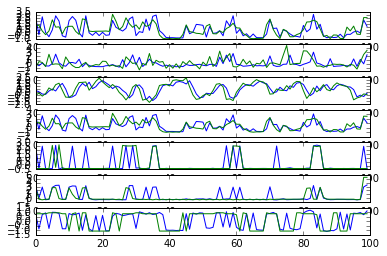

In [575]:
n_samples=1
start = 1000
end = 1100

bd = batchdata.get_value(borrow=True)

data_idx = np.array(range(start,end))
orig_data = np.asarray(bd[data_idx],dtype=theano.config.floatX)


hist_idx = np.array([data_idx - n for n in xrange(1, crbm.delay + 1)]).T
hist_idx = hist_idx.ravel()

orig_history = np.asarray(bd[hist_idx].reshape((len(data_idx), crbm.delay * crbm.n_visible)),dtype=theano.config.floatX)


generated_series = crbm.generate(orig_data, orig_history, n_samples=n_samples,n_gibbs=100)

# append initialization
generated_series = np.concatenate((orig_history.reshape(len(data_idx),
                                                            crbm.delay,
                                                            crbm.n_visible \
                                                            )[:, ::-1, :],
                                       generated_series), axis=1)

# plot first dimension of each sequence
#for i in xrange(len(generated_series)):
    # original
    #start = data_idx[i]
    #plot all time series
    #for j in xrange(crbm.n_visible):
        #plt.subplot(crbm.n_visible, len(generated_series), j+1)
        #plt.plot(bd[start - crbm.delay:start + n_samples - crbm.delay,j],
        #         label='true', linestyle=':')
        #plt.plot(generated_series[i, :n_samples,j], label='predicted',
        #         linestyle='-')

    #leg = plt.legend()
    #ltext = leg.get_texts()  # all the text.Text instance in the legend
    #plt.setp(ltext, fontsize=9)
for i in range(crbm.n_visible):
    poltGEN = generated_series[:,crbm.delay,i]
    plt.subplot(crbm.n_visible, 1, i+1)
    plt.plot(poltGEN)
    plt.plot(batchdata.get_value(borrow=True)[start:end,i])

Generating frame 0


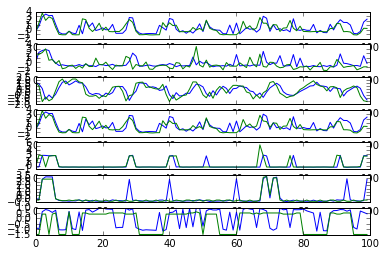

In [576]:
n_samples=1

start = 1000
end = 1100

bd = validationSet.values

data_idx = np.array(range(start,end))
orig_data = np.asarray(bd[data_idx],dtype=theano.config.floatX)


hist_idx = np.array([data_idx - n for n in xrange(1, crbm.delay + 1)]).T
hist_idx = hist_idx.ravel()

orig_history = np.asarray(bd[hist_idx].reshape((len(data_idx), crbm.delay * crbm.n_visible)),dtype=theano.config.floatX)


generated_series = crbm.generate(orig_data, orig_history, n_samples=n_samples,n_gibbs=30)

# append initialization
generated_series = np.concatenate((orig_history.reshape(len(data_idx),
                                                            crbm.delay,
                                                            crbm.n_visible \
                                                            )[:, ::-1, :],
                                       generated_series), axis=1)

# plot first dimension of each sequence
#for i in xrange(len(generated_series)):
    # original
    #start = data_idx[i]
    #plot all time series
    #for j in xrange(crbm.n_visible):
        #plt.subplot(crbm.n_visible, len(generated_series), j+1)
        #plt.plot(bd[start - crbm.delay:start + n_samples - crbm.delay,j],
        #         label='true', linestyle=':')
        #plt.plot(generated_series[i, :n_samples,j], label='predicted',
        #         linestyle='-')

    #leg = plt.legend()
    #ltext = leg.get_texts()  # all the text.Text instance in the legend
    #plt.setp(ltext, fontsize=9)
MSE=[None]*crbm.n_visible
for i in range(crbm.n_visible):
    plotGEN = generated_series[:,crbm.delay,i]
    plt.subplot(crbm.n_visible, 1, i+1)
    plt.plot(plotGEN)
    plt.plot(bd[start:end,i])  
    MSE[i] = (np.sum(np.power(plotGEN - bd[start:end,i],2))/(end-start+1))


In [569]:
MSE

[0.9767222917089402,
 1.1733383300973903,
 0.37706466813272455,
 0.97795653921728554,
 0.58096073313217222,
 0.73585013473128125,
 1.1273965826233756]